# Ending project - Data Science Bootcamp 

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.pipeline import FeatureUnion, Pipeline 
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

# Problem description

Insurance company wants to offer a vehicle insurance to current health policyholders. We will fit the model in order to make the best prediction of the customer response "Yes" or "No". It will help the company determine which customers should they consider while making an offer.

# Dataset description

Data were downloaded from Kaggle website: 
https://www.kaggle.com/arashnic/imbalanced-data-practice

The dataset contains following variables:
- id: Customer ID; numerical
- Gender: Customer sex (Male/Female); categorical
- Age: Age of customer; numerical
- Driving_License: Indicator whether customer has driving license, 0 - "No", 1 - "Yes"; categorical
- Region_Code: Customer's region code; numerical
- Previously_Insured: Indicator if customer has ever been insured, 0 - "No", 1 - "Yes"; categorical
- Vehicle_Age: Age of vehicle divided into three classes, "<1 Year", "1-2 Years", ">2 Years"; categorical
- Vehicle_Damage: Indicator if vehicle has been damaged, 0 - "No", 1 - "Yes"; categorical
- Annual_Premium: Annual amount of money customer pays to insurance company; numerical
- Policy_Sales_Channel: Number of channel through which policy was sold to customer (broker, insurance agent etc.); numerical
- Vintage: Amount of days customer has been insured so far; numerical
- Response: Customer's response to vehicle insurance offer, 0 - "Yes", 1 - "No"; categorical


# Methodology

In this project, we will perform analysis basing on below steps:
1. Exploratory data analysis 
2. Choice of measure - we will choose the best measure related to our business problem.
3. Baseline algorithms - we will test several algorithms to obtain a starting point model performance. 
4. Imbalanced algorithms - we will test some techinques related to imbalanced datasets. 
5. Choice of algorithm and hyperparameters tuning - looking at previous results, we will choose the final algorithm (or combination of algorithms) and tune its hyperparameters.

Methodolgy was inspired by the tutorial:
https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

# 1. Exploratory Data Analysis

Data read:

In [11]:
data=pd.read_csv(r'C:\Users\efkaa\Documents\BOOTCAMP\PROJEKT ZALICZENIOWY\DANE\aug_train.csv')

Let's look how input data look in the dataframe:

In [12]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [4]:
data.shape

(382154, 12)

We will check the column types and if there are any missing values:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


As can be seen from above output, there are no missing values in the dataset. However, we can notice "Driving_License", "Previously Insured" and "Response" columns are classified as integers due to they are already encoded. Let's change their type to object. Moreover, columns "Region_Code" and "Policy_Sales_Channel" should be classified as integers. 

In [13]:
def prepare_data(dt):
    dt.Driving_License=dt.Driving_License.astype('object')
    dt.Previously_Insured=dt.Previously_Insured.astype('object')
    dt.Policy_Sales_Channel=dt.Policy_Sales_Channel.astype('int64')
    dt.Region_Code=dt.Region_Code.astype('int64')
    dt.Gender[dt.Gender=='Male']=1
    dt.Gender[dt.Gender=='Female']=0
    dt.Vehicle_Damage[dt.Vehicle_Damage=='Yes']=1
    dt.Vehicle_Damage[dt.Vehicle_Damage=='No']=0
    dt.Vehicle_Age[dt.Vehicle_Age=='< 1 Year']=0
    dt.Vehicle_Age[dt.Vehicle_Age=='1-2 Year']=1
    dt.Vehicle_Age[dt.Vehicle_Age=='> 2 Years']=2


In [14]:
prepare_data(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  object 
 4   Region_Code           382154 non-null  int64  
 5   Previously_Insured    382154 non-null  object 
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  int64  
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 35.0+ MB


Let's look at relations among all the variables:

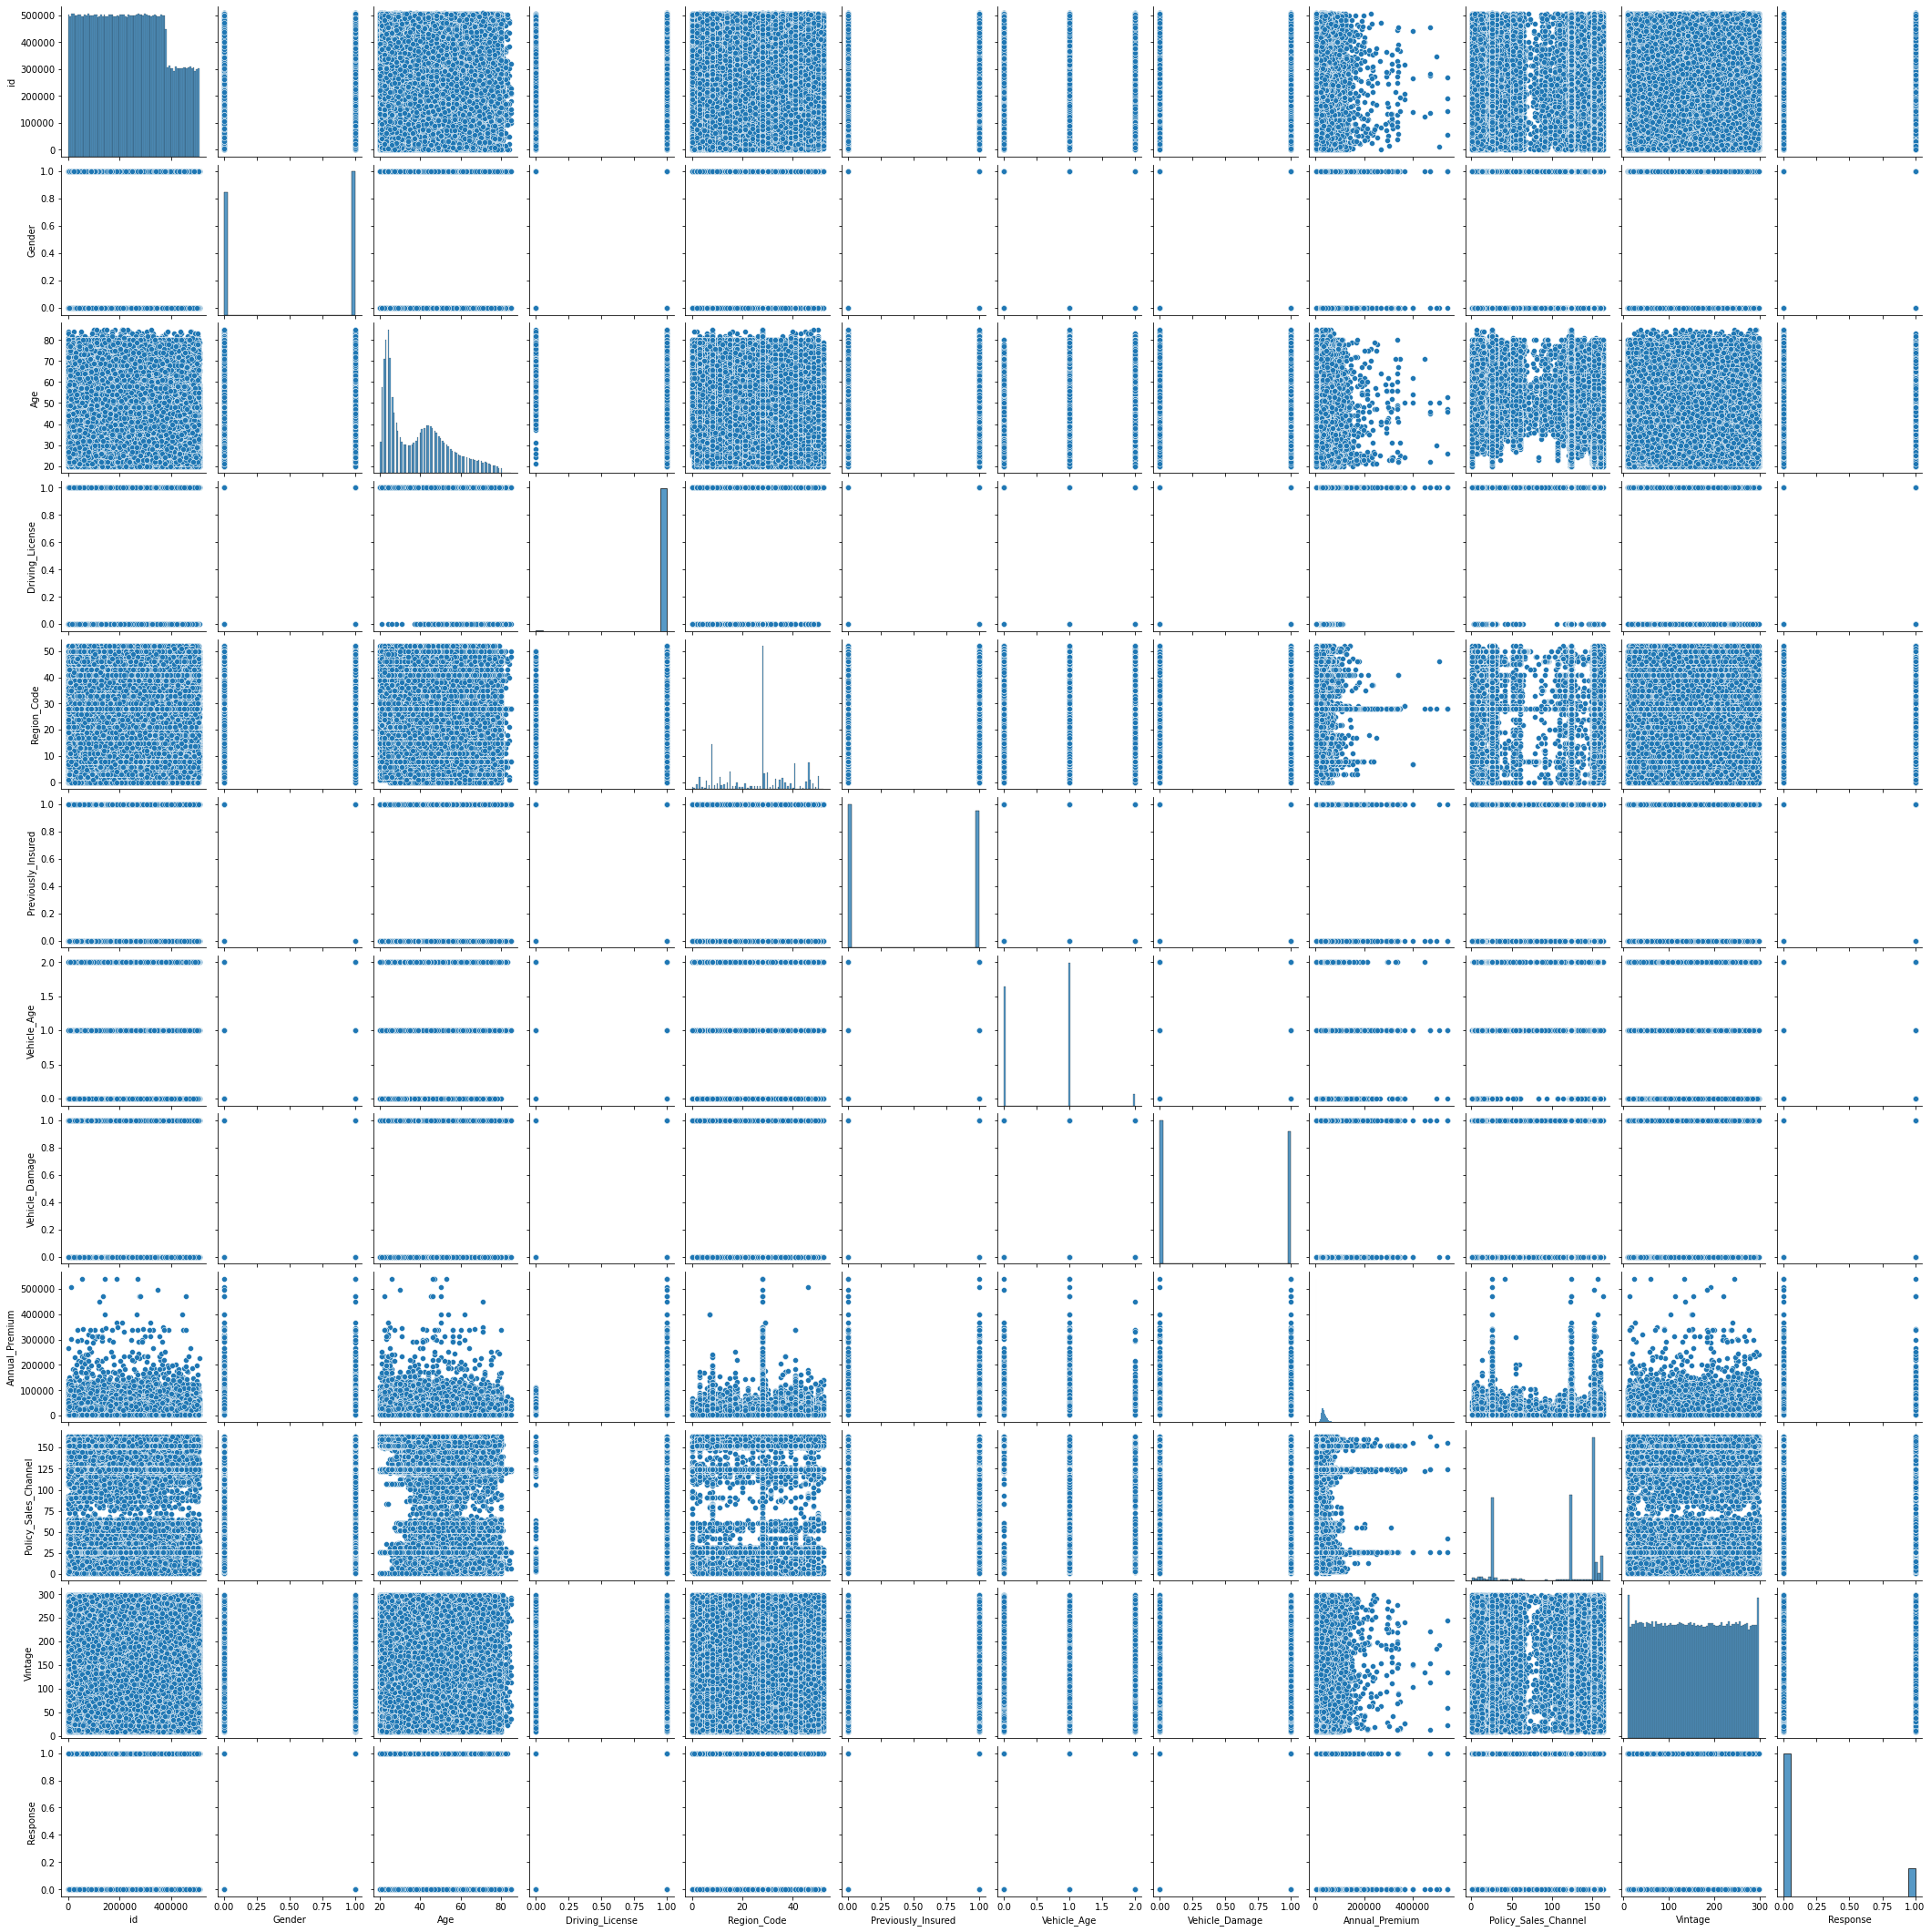

In [8]:
sns.pairplot(data)
plt.show()

We can see from above there are some outliers, especially looking at Annual_Premium variable.

We will check if the dataset is balanced or imbalanced.

In [15]:
data.Response.value_counts(normalize=True)

0    0.836189
1    0.163811
Name: Response, dtype: float64

Clearly we see much more examples of class 0 (~84%) than class 1, which means the set is imbalanced.

Let's divide our dataset into training and test. Training will be used in further data exploration. The two sets will have the same balance due to Response variable.

In [16]:
X, X_test, y, y_test=train_test_split(data.drop('Response',axis=1),data.Response, test_size=0.2, stratify=data.Response,random_state=42)

Below are the basic statistics of numerical columns in the training set:

In [17]:
X.describe()

,id,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
count,305723.000000,305723.000000,305723.000000,305723.000000,305723.000000,305723.000000
mean,234448.204093,38.527101,26.411765,30707.883025,111.914622,154.135453
std,139451.059554,15.209446,13.177876,16986.259659,54.297072,83.723942
min,3.000000,20.000000,0.000000,2630.000000,1.000000,10.000000
25%,115218.000000,25.000000,15.000000,24559.000000,26.000000,81.000000
50%,230573.000000,36.000000,28.000000,31675.000000,140.000000,154.000000
75%,345370.000000,49.000000,35.000000,39424.000000,152.000000,227.000000
max,508143.000000,85.000000,52.000000,540165.000000,163.000000,299.000000


Looking at numerical variables, their values vary from 0 to more than 500,000. Some scaling transformation will be needed in further data preparation.

Gender


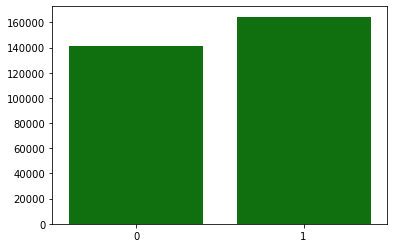

Driving_License


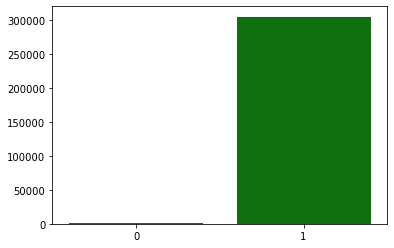

Previously_Insured


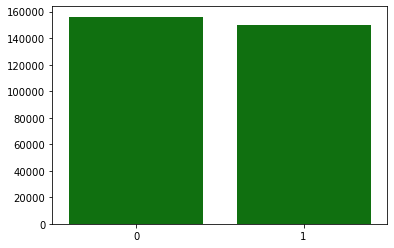

Vehicle_Age


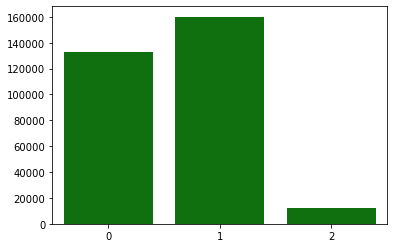

Vehicle_Damage


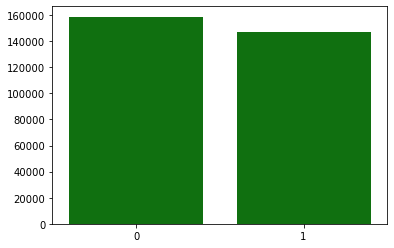

In [18]:
cat_columns = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cat_columns:
    print(f'{col}')
    sns.barplot(x=np.unique(X[col],return_counts=True)[0],y=np.unique(X[col],return_counts=True)[1],color="g")
    plt.show()

From above plots we can see in most cases there is balance between class 0 and 1. The exceptions are Driving_License, where majority of observations belong to class 1, and Vehicle_Age, where class of vehicles older than 2 years is much smaller than other two.

Let's examine numerical variables using histograms and boxplots:

id


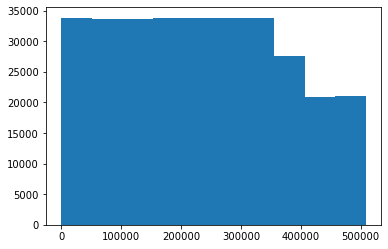

Age


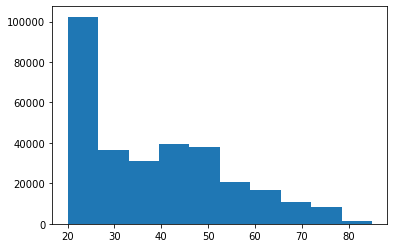

Region_Code


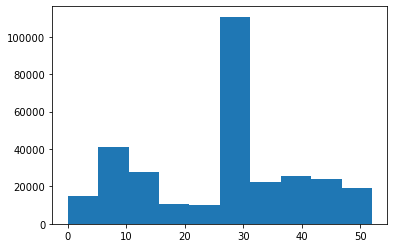

Annual_Premium


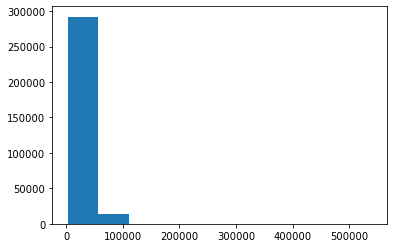

Policy_Sales_Channel


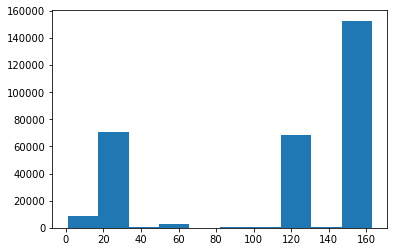

Vintage


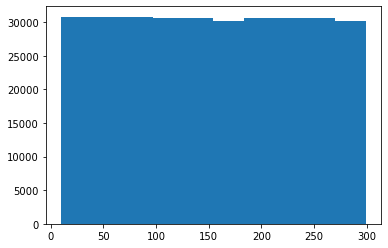

id


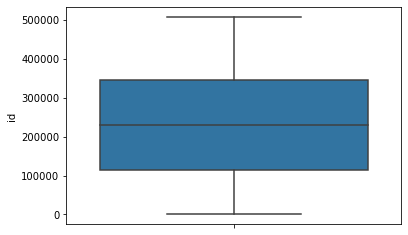

Age


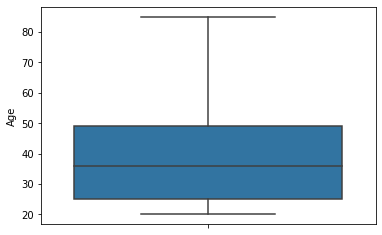

Region_Code


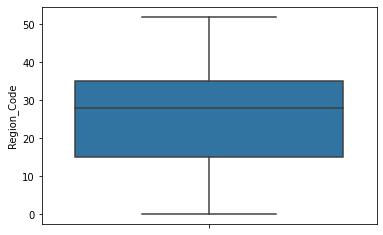

Annual_Premium


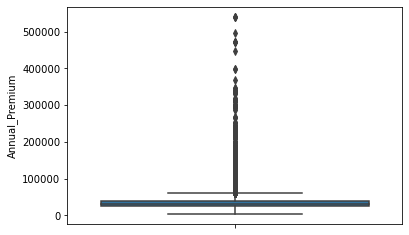

Policy_Sales_Channel


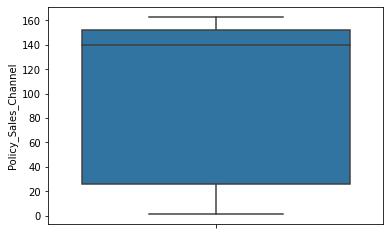

Vintage


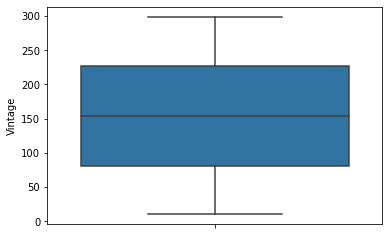

In [19]:
num_columns= X.select_dtypes(include=np.number).columns.tolist()
for col in num_columns:
    print(col)
    plt.hist(X[col])
    plt.show()
for col in num_columns:
    print(col)
    sns.boxplot(y=(X[col]),orient='v')
    plt.show()
    

Conclusions:
1. The largest Age group consist of customers aged between 20 and 30.
2. The largest Region Code group consist of customers with code close to 30.
3. Majority of premiums is lower than 50,000.
4. The most popular policy channels have numbers around 150-160.
5. Outliers can be seen on Annual_Premium boxplot chart.

We will now detect outliers using Interquantile Range.

In [20]:
def IQR(col):
    IQR=col.quantile(0.75)-col.quantile(0.25)
    u=col.quantile(0.75)+1.5*IQR
    l=col.quantile(0.25)-1.5*IQR
    return sum(col>u)+sum(col<l)
for col in num_columns:
    print(col,': ',IQR(X[col]))

id :  0
Age :  0
Region_Code :  0
Annual_Premium :  8392
Policy_Sales_Channel :  0
Vintage :  0


There are more than 8,000 of observations in Annual_Premium column that exceed upper boxplot limit. They will be transformed in further analysis.

# 2. Choice of Metrics

The aim is to predict customers response (Yes or No) to vehicle insurane offer. From business perspective, it is crucial for insurance company to properly choose customers.  The number of clients accepting an offer among all clients company chose should be as high as possible. Therefore models will be measured using precision score. 

# 3. Baseline setting

Firstly we will test several algorithms with default parameters to set the baseline prediction level. 
We will consider following algorithms:
- Naive prediction (Dummy Classifier)
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost


In order to maintain the same 0-1 class balance, Stratified K-Fold with 5 splits will be used as cross-validator. 
Precision will be used as scoring function.

In [5]:
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    def fit(self, X, y = None ):
        return self     
    def transform(self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [6]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_select: list):
        self.columns_to_select = columns_to_select
    def fit( self, X, y = None ):
        return self 
    def transform( self, X, y = None ):
        return X[self.columns_to_select]

For variables where observations exceed lower or upper range of the boxplot, such outliers values will be replaced by those ranges.

In [7]:
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.boundaries = {}
    def fit( self, X, y = None ):
        for col in X:
            IQR = np.nanpercentile(X[col], 75) - np.nanpercentile(X[col], 25)
            l, u = (np.nanpercentile(X[col], 25) - 1.5 * IQR), (np.nanpercentile(X[col], 75) + 1.5 * IQR)
            self.boundaries[col] = [l, u]   
        return self 
    def transform( self, X, y = None ):
        for col in X:
            X.loc[X[col] < self.boundaries[col][0], col] = self.boundaries[col][0]
            X.loc[X[col] > self.boundaries[col][1], col] = self.boundaries[col][1]
        return X

In [44]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)


transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                     ('numerical_pipeline', num_pipeline ) 
                   ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)


final_pipelines = [
    Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('dummy', DummyClassifier(strategy='stratified', random_state=42))
]),
    Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('log_reg', LogisticRegression())
]),

    Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('Decision_Tree', DecisionTreeClassifier())
]),
    Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('rand_forest', RandomForestClassifier())
]), 
    Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('xgb', XGBClassifier())
])
]

cv = StratifiedKFold()
models=['Dummy Classifier', 'Logistic Regression','Decision Tree', 'Random Forest','XGBoost']
scores=[]
for i in range(len(models)):
    n_scores = cross_val_score(final_pipelines[i], X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
    scores.append(np.mean(n_scores))
    mod=final_pipelines[i].fit(X,y)
    y_pred=mod.predict(X_test)
    print(models[i])
    print('Cross validation score: ', scores[i])
    print('Prediction score: ', precision_score(y_test,y_pred))



Dummy Classifier
Cross validation score:  0.16369849246231155
Prediction score:  0.16851762433606954
Logistic Regression
Cross validation score:  0.4738838279395104
Prediction score:  0.4697484704282801
Decision Tree
Cross validation score:  0.4354198932384226
Prediction score:  0.43396522011593297
Random Forest
Cross validation score:  0.5097027866208205
Prediction score:  0.5058907898780862
XGBoost
Cross validation score:  0.5468940466404737
Prediction score:  0.5452000658653054


Conclusions:
1. Making an offer to customers chosen randomly gives ~17% precision score.
2. From more advanced models, the best scores are achieved by Random Forest and XGBoost with both cross validation and prediction greater than 50%, which is around 3 times higher than Dummy Classifier.

## Logistic Regression assumptions check

Although Logistic Regression had 3rd highest score, we will check if there is linear relation between numerical explanatory variables and logit function of probabilities of the target variable. If there is no such relation, this algorithm will not be used in further analysis. 


In [19]:

columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]


num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)


transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)
lr=Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),       
        ('log_reg', LogisticRegression())
    ])
p=lr.fit(X,y).predict_proba(X_test)[:,1]


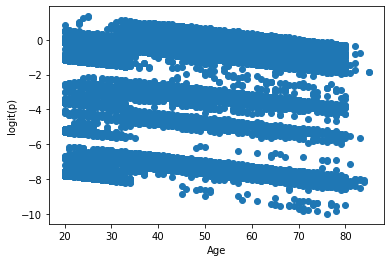

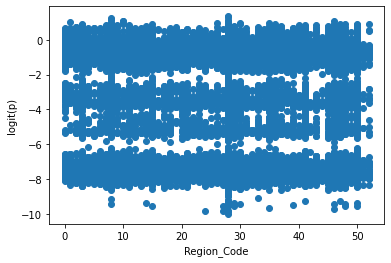

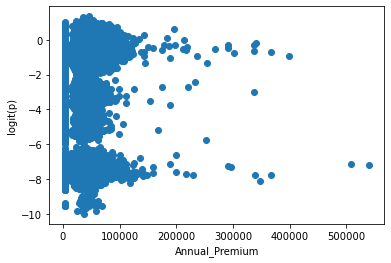

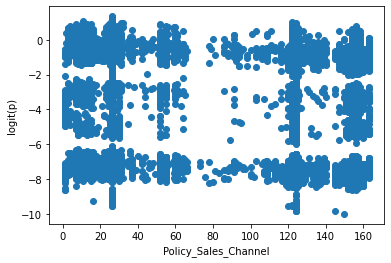

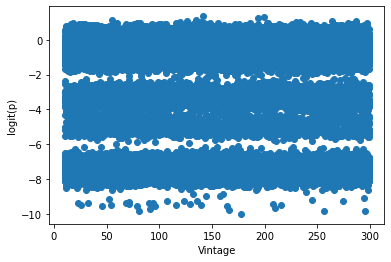

In [20]:
def logit(y):
    return np.log(y/(1-y))

for i in range(1, len(num_columns)):
        plt.scatter(y=logit(p),x=X_test[num_columns[i]])
        plt.xlabel(num_columns[i])
        plt.ylabel('logit(p)')
        plt.show()

The logit function's shape should be close to below:

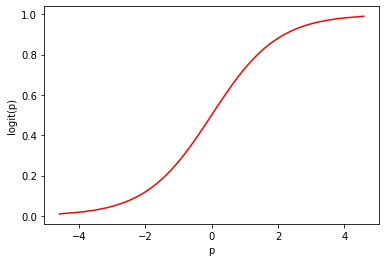

In [45]:
prob=np.linspace(0,1,num=100,endpoint=True)
lg_prob=logit(prob)
plt.plot(lg_prob,prob,c='r')
plt.xlabel('p')
plt.ylabel('logit(p)')
plt.show()

As can be seen on above charts, there is no such relation in our dataset, therefore we will reject Logistic Regression model.

## Feature Selection

Let's now check if Feature Selection improves the score. It will be done using Random Forest feature importances with 200 trees.

In [59]:
sc=StandardScaler()
X_copy=X.drop('id',axis=1)
X_scaled=sc.fit_transform(X_copy)
fi = RandomForestClassifier(200,n_jobs=-1).fit(X_scaled,y).feature_importances_

Gender :  0.011568033151925354
Age :  0.15071338365298909
Driving_License :  0.0005249983105872411
Region_Code :  0.09523819038520565
Previously_Insured :  0.0860526070798775
Vehicle_Age :  0.03273078333757436
Vehicle_Damage :  0.10842252708049277
Annual_Premium :  0.2123187236238446
Policy_Sales_Channel :  0.06488177015074767
Vintage :  0.23754898322675577


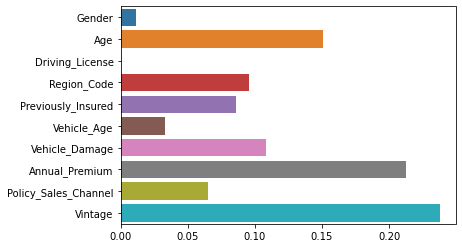

In [61]:
for i in range(len(fi.tolist())):
    print(X_copy.columns[i], ': ', fi.tolist()[i])

    
sns.barplot(x=fi.tolist(),y=X_copy.columns)
plt.show()


We will test several thresholds from range [0.01, 0.09] and see what are the scores for each threshold.

In [64]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
]


num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                     ('numerical_pipeline', num_pipeline ) 
                   ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

cv = StratifiedKFold()
models=['Decision Tree', 'Random Forest','XGBoost']

for t in np.linspace(0.01,0.11,num=5,endpoint=False):
    
    final_pipelines_rf = [
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline), 
        ('Feature_Selection_rf', SelectFromModel(RandomForestClassifier(100), threshold=t)),
        ('dt', DecisionTreeClassifier())
    ]),
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline), 
        ('Feature_Selection_rf', SelectFromModel(RandomForestClassifier(100), threshold=t)),
        ('rand_forest', RandomForestClassifier())
    ]),
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline), 
        ('Feature_Selection_rf', SelectFromModel(RandomForestClassifier(100), threshold=t)),
        ('xgb', XGBClassifier())
    ])
    ]
    print('')
    print('Random Forest selector, threshold: ',t)
    scores_rf=[]
    for i in range(len(models)):
        n_scores = cross_val_score(final_pipelines_rf[i], X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
        scores_rf.append(np.mean(n_scores))
        mod=final_pipelines_rf[i].fit(X,y)
        y_pred=mod.predict(X_test)
        print(models[i])
        print('Cross validation score: ', scores_rf[i])
        print('Prediction score: ', precision_score(y_test,y_pred))    




Random Forest selector, threshold:  0.01
Decision Tree
Cross validation score:  0.4366414895598525
Prediction score:  0.4368450082735797
Random Forest
Cross validation score:  0.5099013282671373
Prediction score:  0.5070596722663094
XGBoost
Cross validation score:  0.5475050394144787
Prediction score:  0.5411558669001751

Random Forest selector, threshold:  0.03
Decision Tree
Cross validation score:  0.431981249774174
Prediction score:  0.4381004882658686
Random Forest
Cross validation score:  0.5035876400012267
Prediction score:  0.5106034217805553
XGBoost
Cross validation score:  0.546554576752388
Prediction score:  0.5454980842911877

Random Forest selector, threshold:  0.05
Decision Tree
Cross validation score:  0.43201280292835686
Prediction score:  0.432357813362783
Random Forest
Cross validation score:  0.5015532697769565
Prediction score:  0.5068790731354091
XGBoost
Cross validation score:  0.5436961780223997
Prediction score:  0.5454980842911877

Random Forest selector, thres

Conclusions:

1. Feature Selection do not significantly improve scores.
2. It will not be applied in further steps.

# 4. Imbalanced algorithms

In this section we will test algorithms dedicated to imbalanced datasets. Models from previous section will be used with default parameters. The aim is to see which method improves the best our baseline scores.

## 4.1 SMOTENC 

We will test SMOTENC algorithm as it can be applied to both numerical and categorical variables. The parameter that needs to be tuned is "sampling_strategy". Currently our minority class is around 20% of the majority class.

In [28]:
y.value_counts()[1]/y.value_counts()[0]

0.195902864161601

5 strategies, from 0.2 to 0.6 will be tested.

In [22]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]

num_pipeline = imbPipeline(num_steps)
cat_pipeline = imbPipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

final_pipelines = [
        imbPipeline(steps = [
        ('combined_pipeline', combined_pipeline), 
        ('SMOTENC', SMOTENC(categorical_features=[0,2,4,5,6])),    
        ('Decision_Tree', DecisionTreeClassifier())
    ]),
        imbPipeline(steps = [
        ('combined_pipeline', combined_pipeline),
        ('SMOTENC', SMOTENC(categorical_features=[0,2,4,5,6])),    
        ('rand_forest', RandomForestClassifier())
    ]),
        imbPipeline(steps = [
        ('combined_pipeline', combined_pipeline), 
        ('SMOTENC', SMOTENC(categorical_features=[0,2,4,5,6])),
        ('xgb', XGBClassifier())
    ])
    ]

cv = StratifiedKFold()
models=['Decision Tree', 'Random Forest','XGBoost']
scores=[]
      
pg=dict(SMOTENC__sampling_strategy=np.linspace(0.2,0.6,num=5,endpoint=True))

for i in range(len(models)):
        grid = GridSearchCV(estimator=final_pipelines[i], param_grid=pg, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
        gf=grid.fit(X,y)
        y_pred=gf.best_estimator_.predict(X_test)
        print(models[i])
        print('Cross validation score: ', gf.best_score_)
        print('Prediction score: ', precision_score(y_test,y_pred))
        print('Threshold: ', gf.best_params_)       


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Decision Tree
Cross validation score:  0.4342232590592404
Prediction score:  0.43240075023444824
Threshold:  {'SMOTENC__sampling_strategy': 0.2}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Random Forest
Cross validation score:  0.5104815907235769
Prediction score:  0.5055578011317704
Threshold:  {'SMOTENC__sampling_strategy': 0.2}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBoost
Cross validation score:  0.5437782287833278
Prediction score:  0.5398388540734109
Threshold:  {'SMOTENC__sampling_strategy': 0.2}


## 4.2 Cost-sensitive learning

Another method dedicated for imbalanced datasets will put more importance on class 1. The penalty for assigning an observation wrongly to class 1 will be higher than to class 0.
- For Decision Tree and Random Forest, "class_weight" parameter will be tuned,
- For XGBoost we will tune "scale_pos_weight".

The 0-1 class ratio in our training data:

In [27]:
y.value_counts()[0]/y.value_counts()[1]

5.104570595635071

We will test weights from 5 to 25, increasing by 5.

In [23]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

final_pipelines = [
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('model', DecisionTreeClassifier())
    ]),
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('model', RandomForestClassifier())
    ]), 
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('model', XGBClassifier())
    ])
    ]

cv = StratifiedKFold()
models=['Decision Tree', 'Random Forest','XGBoost']     
        
pg=dict(model__class_weight=[{0:1, 1:w} for w in range(5,26,5)])

for i in range(len(models)-1):
        grid = GridSearchCV(estimator=final_pipelines[i], param_grid=pg, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
        gf=grid.fit(X,y)
        y_pred=gf.best_estimator_.predict(X_test)
        print(models[i])
        print('Cross validation score: ', gf.best_score_)
        print('Prediction score: ', precision_score(y_test,y_pred))
        print('Threshold: ', gf.best_params_) 
        
pg_xgb=dict(model__scale_pos_weight=np.linspace(5,26,num=5,endpoint=False))
grid_xgb = GridSearchCV(estimator=final_pipelines[2], param_grid=pg_xgb, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
gf_xgb=grid_xgb.fit(X,y)
y_pred_xgb=gf_xgb.best_estimator_.predict(X_test)
print(models[2])
print('Cross validation score: ', gf_xgb.best_score_)
print('Prediction score: ', precision_score(y_test,y_pred_xgb))
print('Threshold: ', gf_xgb.best_params_)

Decision Tree
Cross validation score:  0.440891870068604
Prediction score:  0.4375970999482134
Threshold:  {'model__class_weight': {0: 1, 1: 20}}
Random Forest
Cross validation score:  0.5148356333980364
Prediction score:  0.5072076261334574
Threshold:  {'model__class_weight': {0: 1, 1: 25}}
XGBoost
Cross validation score:  0.4139767188745115
Prediction score:  0.41348242583953565
Threshold:  {'model__scale_pos_weight': 5.0}


## 4.3 Probability threshold calibration

Last tested method will be to calibrate probability threshold, above which observations are assigned to class 1. We will validate 100 thresholds from interval [0,1].

In [24]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

final_pipelines = [
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('Decision_Tree', DecisionTreeClassifier())
    ]),
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('rand_forest', RandomForestClassifier())
    ]), 
        Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('xgb', XGBClassifier())
    ])
    ]
    
models=['Decision Tree', 'Random Forest','XGBoost']
thresholds=np.linspace(0,1,num=100,endpoint=True)
th=[]

for i in range(len(models)):    
    args=[]
    for j in range(21):
        scores=[]
        X_tr,X_t,y_tr,y_t=train_test_split(X,y,test_size=0.2,random_state=42)
        probas = final_pipelines[i].fit(X_tr,y_tr).predict_proba(X_test)
        probas=probas[:,1]
        for t in thresholds:
            y_pred=(probas>t).astype(int)
            scores.append(precision_score(y_test,y_pred))
        args.append(np.argmax(scores))
    print(models[i],': ', scores[statistics.mode(args)],', ', thresholds[statistics.mode(args)])
    th.append(statistics.mode(args))        


Decision Tree :  0.42950176539819535 ,  0.5050505050505051
Random Forest :  0.6666666666666666 ,  0.98989898989899
XGBoost :  0.6666666666666666 ,  0.6060606060606061


# 5. Choice of algorithm and hyperparameters tuning

We will tune parameters for two models: Random Forest and XGBoost as they were performing the best in previous steps, and then calibrate probability threshold to obtain final precision score. Probability calibration turned out to be the best algorithm in section 4.

## Random Forest tuning

For Random Forest, number of trees and number of features will be tuned.

In [25]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)


model = Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('rf', RandomForestClassifier())   
])
cv = StratifiedKFold()
params=dict(
    rf__n_estimators=np.linspace(100,200,num=10,endpoint=True).astype(int),
    rf__max_features=['auto','log2',2,3,4,5,6]    
)

grid = GridSearchCV(estimator=model, param_grid=params, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
gf=grid.fit(X,y)
prob=gf.best_estimator_.predict_proba(X_test)[:,1]

thresholds=np.linspace(0,1,num=100,endpoint=True)
scores=[]
for t in thresholds:
    y_pred=(prob>t).astype(int)
    scores.append(precision_score(y_test,y_pred))
        
idx=np.argmax(scores)

print('Model: ', gf.best_params_)
print('Cross validation score: ', gf.best_score_)
print('Prediction score - precision: ', scores[idx])
print('Threshold: ', thresholds[idx])

Model:  {'rf__max_features': 2, 'rf__n_estimators': 144}
Cross validation score:  0.5118782618621414
Prediction score - precision:  0.8
Threshold:  0.9595959595959597


## XGBoost tuning

We will tune number of trees used in XGBoost.

In [26]:
columns_to_remove=['id']

num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('remove_columns', RemoveColumnsTransformer(columns_to_remove)),
            ('remove_outliers', RemoveOutliersTransformer()),
            ('scaler', StandardScaler()) 

]

cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))
    ]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                         ('numerical_pipeline', num_pipeline ) 
                       ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)


model = Pipeline(steps = [
        ('combined_pipeline', combined_pipeline),   
        ('xgb', XGBClassifier(n_jobs=-1))   
])
cv = StratifiedKFold()
params=dict(
    xgb__n_estimators=np.linspace(100,200,num=10,endpoint=True).astype(int)
   
)

grid = GridSearchCV(estimator=model, param_grid=params, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
gf=grid.fit(X,y)
prob=gf.best_estimator_.predict_proba(X_test)[:,1]

thresholds=np.linspace(0,1,num=100,endpoint=True)
scores=[]
for t in thresholds:
    y_pred=(prob>t).astype(int)
    scores.append(precision_score(y_test,y_pred))
        
idx=np.argmax(scores)

print('Model: ', gf.best_params_)
print('Cross validation score: ', gf.best_score_)
print('Prediction score - precision: ', scores[idx])
print('Threshold: ', thresholds[idx])

Model:  {'xgb__n_estimators': 166}
Cross validation score:  0.5480769827483172
Prediction score - precision:  1.0
Threshold:  0.6666666666666667


# Summary

Calibrating probability threshold for final Random Forest and XGBoost models resulted in following precision scores:
- Random Forest: 0.8 with threshold around 0.96,
- XGBoost: 1 with threshold around 0.67.

From above results we can conclude both models improved the baseline cross-validation and prediction scores. XGBoost has better results, while Random Forest is associated with very high probability threshold. In general, it is more beneficial for insurance company to apply Machine Learning algorithms rather than making an offer to randomly chosen customers. There is still area to improve Random Forest algorithm, for example by tuning more parameters. 